                                file  scanid scan_types
0              COVID/Covid (640).png       0      COVID
1              COVID/Covid (210).png       0      COVID
2              COVID/Covid (705).png       0      COVID
3              COVID/Covid (355).png       0      COVID
4              COVID/Covid (586).png       0      COVID
...                              ...     ...        ...
2476  non-COVID/Non-Covid (1052).png       1  non-COVID
2477    non-COVID/Non-Covid (51).png       1  non-COVID
2478  non-COVID/Non-Covid (1117).png       1  non-COVID
2479   non-COVID/Non-Covid (671).png       1  non-COVID
2480   non-COVID/Non-Covid (221).png       1  non-COVID

[2481 rows x 3 columns]
                                file  scanid scan_types
0                COVID/Covid (2).png       0      COVID
1               COVID/Covid (34).png       0      COVID
2     non-COVID/Non-Covid (1017).png       1  non-COVID
3      non-COVID/Non-Covid (911).png       1  non-COVID
4              COVID/Co

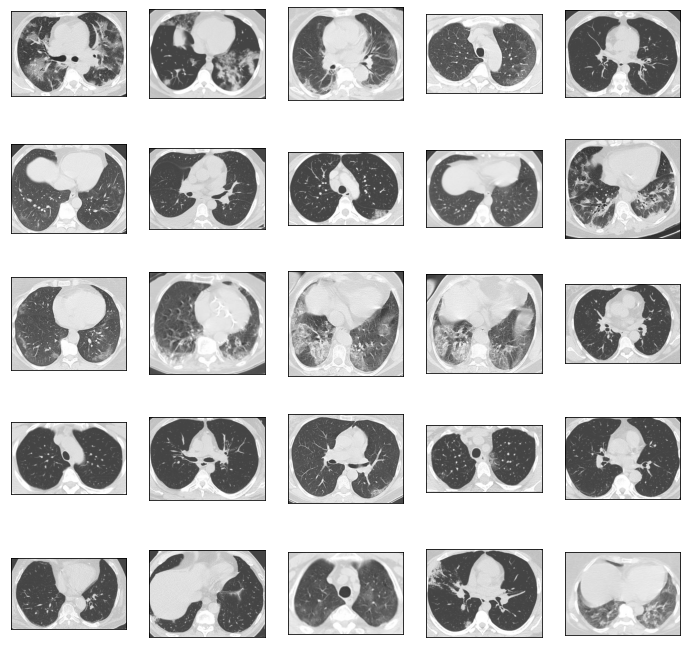

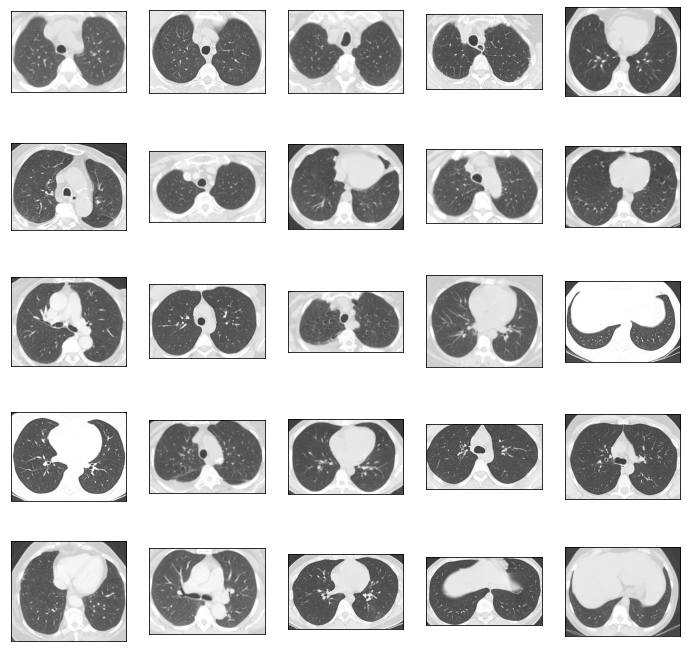

In [ ]:
#Importing libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.densenet import DenseNet121
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm

# Data imports
scan_types = ['COVID','non-COVID']
covid_scans = 'data_set'
train_set = os.path.join(covid_scans)

# Data Cleaning
def data_cleaning(scan_types):
    training_scans = []
    for defects_id, sp in enumerate(scan_types):
        for file in os.listdir(os.path.join(train_set, sp)):
            training_scans.append(['{}/{}'.format(sp, file), defects_id, sp])
    train_var = pd.DataFrame(training_scans, columns=['file', 'scanid','scan_types'])
    return train_var
    
data_cleaned = data_cleaning(scan_types)
print(data_cleaned)

#Data random for better results
def data_randomization(data_cleaned):
    data_cleaned = data_cleaned.sample(frac=1, random_state=42) 
    data_cleaned.index = np.arange(len(data_cleaned)) 
    return data_cleaned

data_random = data_randomization(data_cleaned)
print(data_random)

#Plotting data
def plot_images(defect_types, rows, cols,):
    fig, axis = plt.subplots(rows, cols, figsize=(12, 12))
    file_detection = data_random['file'][data_random['scan_types'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(train_set, file_detection[n])
            axis[i, j].set_xticks([])
            axis[i, j].set_yticks([])
            axis[i, j].imshow(cv2.imread(image_path))
            n += 1
plot_images('COVID', 5, 5)
plot_images('non-COVID', 5, 5)

In [8]:
#Image Rezize 
IMAGE_SIZE = 224
def input_image(filepath):
    return cv2.imread(os.path.join(train_set, filepath)) 
    
def resize_scan_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)
#Training data
X_train_data = np.zeros((data_random.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(data_random['file'].values)):
    image = input_image(file)
    if image is not None:
        X_train_data[i] = resize_scan_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train_data = X_train_data / 255.
print('Train Shape: {}'.format(X_train_data.shape))
Y_train = data_random['scanid'].values
Y_train = to_categorical(Y_train, num_classes=2)
BATCH_SIZE = 32
X_train_data, X_val, Y_train, Y_val = train_test_split(X_Train_data, Y_train, test_size=0.2, random_state=42)





2481it [00:15, 156.51it/s]


Train Shape: (2481, 64, 64, 3)


In [21]:
from keras.applications.densenet import DenseNet201
EPOCHS = 7
SIZE=224
N_ch=3
#This is a pre-made model from keras.io
def build_resnet50():
    densetnet201 = DenseNet201(weights='imagenet', include_top=False)

    input = Input(shape=(224, 224, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densetnet201(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    model = Model(input,output)
    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

80150528/80134624 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
____________________________________________________________

/Users/josiahcornelius/.conda/envs/BankLoan/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=10, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=20, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2, 
                        horizontal_flip=True) 
datagen.fit(X_train_data)
hist = model.fit_generator(datagen.flow(X_train_data, Y_train, batch_size=32),
               steps_per_epoch=X_train_data.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))


In [ ]:
model = load_model('model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

In [ ]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/Users/josiahcornelius/Desktop/CT_COVID_SCANS/chest-ct-lungs.png', grayscale=False, target_size=(224, 224))
show_img=image.load_img('/Users/josiahcornelius/Desktop/CT_COVID_SCANS/chest-ct-lungs.png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Diagnois:',disease_class[ind])
